In [1]:
from qiskit import QuantumCircuit, execute
import matplotlib.pyplot as plt
from qiskit.test.mock import FakeManhattan, FakeBoeblingen, FakeQuito
from qiskit.transpiler import CouplingMap
from qiskit.visualization import plot_gate_map, plot_circuit_layout, plot_histogram
from qiskit.converters import circuit_to_dag
import retworkx as rx
import numpy as np
from retworkx.visualization import mpl_draw

/Applications/anaconda3/envs/qiskit-terra-dev/lib/python3.8/site-packages/unittest2/compatibility.py:143: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3, and in 3.9 it will stop working
  class ChainMap(collections.MutableMapping):


In [2]:
from qiskit.transpiler.passes.layout import CSPWCRLayout

/Applications/anaconda3/envs/qiskit-terra-dev/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [3]:
from exp.circuit_generators import graphstate_complete

In [4]:
from qiskit.transpiler.passes import VF2RSLayout

In [5]:
def run_layout_selector_on_circuit(circuit, layout_selector, backend, **kwargs):
    backend_config = backend.configuration()
    coupling_map = CouplingMap(backend_config.coupling_map)
    pass_ = layout_selector(CouplingMap(backend.configuration().coupling_map), **kwargs)
    property_set = {}
    pass_(circuit, property_set)
    circuit._layout = property_set['layout']
    return circuit

def layout_on_circuit(circuit, layout_selector, backend, **kwargs):
    circuit = run_layout_selector_on_circuit(circuit, layout_selector, backend, **kwargs)
    return plot_circuit_layout(circuit, backend)

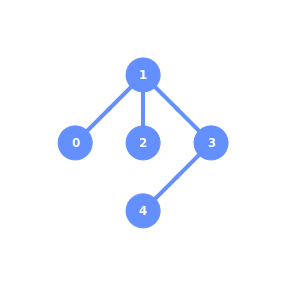

In [6]:
backend = FakeQuito()
plot_gate_map(backend)

In [7]:
circuit = QuantumCircuit(3, 3)
circuit.cx(0, 1)
circuit.cx(1, 2)

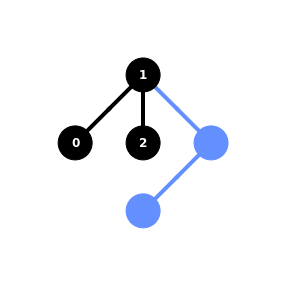

In [8]:
layout_on_circuit(circuit, VF2RSLayout, backend)

In [9]:
circuit = graphstate_complete(3)

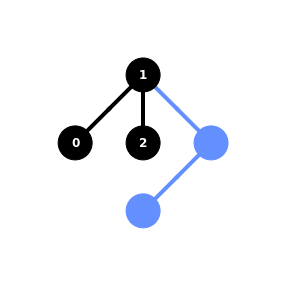

In [10]:
layout_on_circuit(circuit, VF2RSLayout, backend)

In [11]:
coupling_map = CouplingMap(backend.configuration().coupling_map)
backend = FakeManhattan()

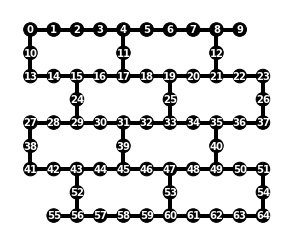

In [12]:
circuit = graphstate_complete(65)
layout_on_circuit(circuit, VF2RSLayout, backend)

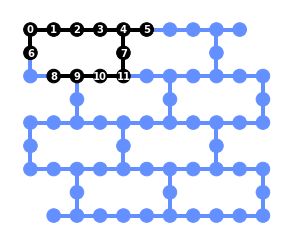

In [13]:
circuit = graphstate_complete(12)
layout_on_circuit(circuit, VF2RSLayout, backend)